In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import json
import os
import re
import cv2
from keras.utils.np_utils import to_categorical  
import h5py
import sys
import time

In [2]:
tf.__version__

'1.5.0'

In [3]:
# defining different variables
data_dir = '../data/NIST19_combined/'
img_width = 140
img_height = 70

# reading the maps
label_cls_name_map = {}
label_name_cls_map = {}
with open('ocr_checkpoints/label_cls_name.json', 'r') as f:
    label_cls_name_map = json.loads(f.read())
    
for k,v in label_cls_name_map.iteritems():
    label_name_cls_map[v] = k

In [21]:
# train dataset inputs and targets
train_inputs = []
train_targets = []
train_image_names = os.listdir(os.path.join(data_dir,'train_images'))
train_df = pd.read_csv(os.path.join(data_dir, 'ocr_combined_train_annotations.csv'))
for train_image_name in train_image_names:
    full_image_path = os.path.join(os.path.join(data_dir, 'train_images'), train_image_name)
    image_np = cv2.imread(full_image_path, 0) # reading the image as 1 channel
    image_np = cv2.resize(image_np, (img_width, img_height), interpolation = cv2.INTER_AREA)
    train_inputs.append(image_np)
    # get the target
    target_ = ''.join(train_df[train_df['filename']==train_image_name]['class'].tolist())
    train_targets.append(target_)
    
# test dataset inputs and targets
test_inputs = []
test_targets = []
test_image_names = os.listdir(os.path.join(data_dir,'test_images'))
test_df = pd.read_csv(os.path.join(data_dir, 'ocr_combined_test_annotations.csv'))
for test_image_name in test_image_names:
    full_image_path = os.path.join(os.path.join(data_dir, 'test_images'), test_image_name)
    image_np = cv2.imread(full_image_path, 0)
    image_np = cv2.resize(image_np, (img_width, img_height), interpolation = cv2.INTER_AREA)
    test_inputs.append(image_np)
    # get the target
    target_ = ''.join(test_df[test_df['filename']==test_image_name]['class'].tolist())
    test_targets.append(target_)

In [22]:
train_inputs_ = np.array(train_inputs)
train_targets_ = np.array(train_targets)
test_inputs_ = np.array(test_inputs)
test_targets_ = np.array(test_targets)
print 'Data loaded successfully !!!'

Data loaded successfully !!!


In [56]:
train_inputs_ = np.transpose(train_inputs_, (0,2,1))
test_inputs_ = np.transpose(test_inputs_, (0,2,1))

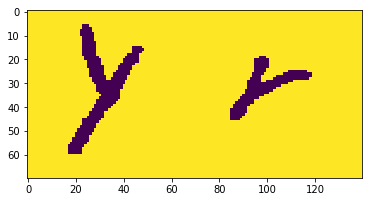

In [60]:
plt.imshow(train_inputs_[0].T)

In [61]:
print train_inputs_.shape
print train_targets_.shape
print test_inputs_.shape
print test_targets_.shape

(20000, 140, 70)
(20000,)
(2000, 140, 70)
(2000,)


## Convert labels into sparse matrix for CTC Loss

TMQFnNPH


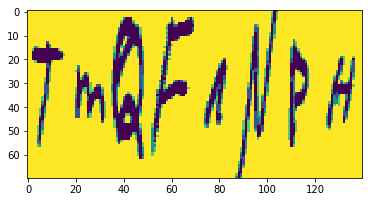

In [62]:
plt.imshow(train_inputs_[1].T)
print train_targets_[1]

In [63]:
def convert_labels_to_integer(labels):
    labels_list = list(labels)
    int_labels_list = map(lambda x: int(label_name_cls_map[x]), labels_list)
    return int_labels_list

train_targets_integer = map(convert_labels_to_integer, train_targets_)
test_targets_integer = map(convert_labels_to_integer, test_targets_)

In [64]:
def sparse_tuple_from(sequences, dtype=np.int32):
    """Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n]*len(seq), range(len(seq))))
        values.extend(seq)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1]+1], dtype=np.int64)

    return indices, values, shape

train_targets_sparse = sparse_tuple_from(train_targets_integer)
test_targets_sparse = sparse_tuple_from(test_targets_integer)


In [69]:
train_seq_len = [140]*train_inputs_.shape[0] 
test_seq_len = [140]*test_inputs_.shape[0] 

## MODEL LSTM + CTC

In [83]:
timesteps_size = 140
num_hidden_units = 140
num_classes = 62
num_epochs = 10
num_examples = train_inputs_.shape[0]
batch_size=200
num_batches_per_epoch = num_examples/batch_size

graph  = tf.Graph()
with graph.as_default():
    # batch_size x step_size x element_size
    inputs = tf.placeholder(tf.float32, [None, timesteps_size, img_height])
    targets = tf.sparse_placeholder(tf.int32)
    seq_len = tf.placeholder(tf.int32, [None])
    cell = tf.contrib.rnn.LSTMCell(num_hidden_units)
    # batch_size x timesteps x hidden_layer_size
    outputs, _ = tf.nn.dynamic_rnn(cell, inputs, seq_len, dtype=tf.float32)
    shape = tf.shape(inputs)
    batch_s, max_timesteps = shape[0], shape[1]
    # batch_size * timesteps x hidden_layer_size
    outputs = tf.reshape(outputs, [-1, num_hidden_units])
    
    W = tf.Variable(tf.truncated_normal([num_hidden_units, num_classes], stddev=0.1))
    b = tf.Variable(tf.constant(0., shape=[num_classes]))
    logits = tf.matmul(outputs, W) + b
    logits = tf.reshape(logits, [batch_s, -1, num_classes])
    logits = tf.transpose(logits, (1, 0, 2))
    
    loss = tf.nn.ctc_loss(targets, logits, seq_len )
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.MomentumOptimizer(1e-2, 0.9).minimize(cost)
    
    decoded, log_prob = tf.nn.ctc_greedy_decoder(logits, seq_len)
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32), targets))
    
    session =  tf.Session()

    # Initializate the weights and biases
    session.run(tf.global_variables_initializer())
    
    for curr_epoch in range(num_epochs):
        train_cost = train_ler = 0
        start = time.time()

        for batch in range(num_batches_per_epoch):
            feed = {inputs: train_inputs_,
                    targets: train_targets_sparse,
                seq_len: train_seq_len}

        batch_cost, _ = session.run([cost, optimizer], feed)
        train_cost += batch_cost*batch_size
        train_ler += session.run(ler, feed_dict=feed)*batch_size

    train_cost /= num_examples
    train_ler /= num_examples

    val_feed = {inputs: test_inputs_,
                targets: test_targets_sparse,
                seq_len: test_seq_len}

    val_cost, val_ler = session.run([cost, ler], feed_dict=val_feed)

    log = "Epoch {}/{}, train_cost = {:.3f}, train_ler = {:.3f}, val_cost = {:.3f}, val_ler = {:.3f}, time = {:.3f}"
    print(log.format(curr_epoch+1, num_epochs, train_cost, train_ler, val_cost, val_ler, time.time() - start))
        

In [ ]:
# Decoding
d = session.run(decoded[0], feed_dict=feed)
str_decoded = ''.join([chr(x) for x in np.asarray(d[1]) + FIRST_INDEX])
# Replacing blank label to none
str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
# Replacing space label to space
str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')

print('Original:\n%s' % original)
print('Decoded:\n%s' % str_decoded)